# **Waze App User Churn Prediction | Binomial Logistic Regression Model**

## Goals: 
* Use the Waze app user data to build and evaluate the performance of a binomial logistic regression model.
  
* Analyze the regression model to reveal important variable relationships and predict user churn, which can inform decisions for marketing and product development of the Waze app. 

# **PACE stages**
Throughout these project notebooks, you'll see references to the problem-solving framework PACE. The following notebook components are labeled with the respective PACE stage: Plan, Analyze, Construct, and Execute.

### **Task 1. Imports and data loading**

In [1]:
# Packages for numerics + dataframes
import numpy as np 
import pandas as pd

# Packages for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Packages for Logistic Regression & Confusion Matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

In [2]:
# Load the dataset
df = pd.read_csv('waze_dataset.csv')

## **PACE: Analyze**

### **Task 2a. Explore data with Exploratory Data Analysis:** 
Discover the data, look for correlations, identify missing data, potential outliers, and duplicates

In [3]:
print(df.shape)
df.info()

(14999, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


> There are 700 missing values in the `label` column. 

In [4]:
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


#### Removing the ID column since it can't be used in the analysis: 

In [5]:
df.drop('ID', axis=1, inplace=True)

#### Checking the class balance of the dependent (target) variable, `label`:

In [6]:
df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

> Less than 18% of the users churned, while more than 82% are retained. The dataset has a class imbalance, but not extremely so. It can be modeled without any class rebalancing (e.g. upsampling, downsampling)

#### Checking for columns with potential outliers: 

In [7]:
df.describe(include='all')

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
count,14299,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,retained,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,iPhone
freq,11763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9672
mean,NaN,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879,NaN
std,NaN,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036,NaN
min,NaN,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,NaN
25%,NaN,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000,NaN
50%,NaN,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000,NaN
75%,NaN,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000,NaN


> By assessing the quartile values, standard deviation, and maximum values, the following columns all seem to have outliers:
> * `drives`
> * `sessions`
> * `total_sessions`
> * `total_navigations_fav1`
> * `total_navigations_fav2`
> * `driven_km_drives`
> * `duration_minutes_drives`

### **Task 2b. Create features:**
##### Create features that might address the business problem

#### **`km_per_driving_day`**

In [8]:
# 1. Convert infinite values to zero
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### **`professional_driver`**

##### Creating a feature that separates professional drivers from other drivers:
* **`professional_driver`**: 1 for users who had 60 or more drives **and** droves on 15 or more days in the last month. 

In [9]:
# Create `professional_driver` column
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

In [10]:
# 1. Check count of professionals and non-professionals
df['professional_driver'].value_counts()

# 2. Check in-class churn rate
df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: proportion, dtype: float64

> The churn rate for professional drivers is 7.6%, while the churn rate for non-professionals is 19.9%. This seems like it could add predictive signal to the model.

## **PACE: Construct**

### **Task 3a. Preparing variables**

#### Checking the data type of the `label` column and identifying missing values: 

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    14299 non-null  object 
 1   sessions                 14999 non-null  int64  
 2   drives                   14999 non-null  int64  
 3   total_sessions           14999 non-null  float64
 4   n_days_after_onboarding  14999 non-null  int64  
 5   total_navigations_fav1   14999 non-null  int64  
 6   total_navigations_fav2   14999 non-null  int64  
 7   driven_km_drives         14999 non-null  float64
 8   duration_minutes_drives  14999 non-null  float64
 9   activity_days            14999 non-null  int64  
 10  driving_days             14999 non-null  int64  
 11  device                   14999 non-null  object 
 12  km_per_driving_day       14999 non-null  float64
 13  professional_driver      14999 non-null  int32  
dtypes: float64(4), int32(1

> The 700 missing values can be dropped since there is no evidence of a non-random cause (from the previous exploratory data analysis) and the missing values only comprise less than 5% of the data. 

In [12]:
# Drop rows with missing data in `label` column
df = df.dropna(subset = 'label', axis=0).reset_index(drop=True)
df.head()

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,professional_driver
0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,1
1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0
4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,1


#### Checking for duplicated observations in the dataset: 

In [13]:
# Check for duplicates in the observations
df.duplicated().value_counts()

False    14299
Name: count, dtype: int64

> There are no duplicated values in the dataset. 

#### **Imputing outliers**

Previously, it was determined that seven of the variables had clear signs of containing outliers:

* `sessions`
* `drives`
* `total_sessions`
* `total_navigations_fav1`
* `total_navigations_fav2`
* `driven_km_drives`
* `duration_minutes_drives`

For this analysis, the value of the **95th percentile** of each column is used to replace any value in that column that exceeds the 95th percentile. 

In [14]:
# Impute outliers
def outlier_imputer(column_str, percentile): 
    threshold = df[column_str].quantile(percentile)
    df.loc[df[column_str]>threshold, column_str] = threshold

    print(f'{column_str: >40} | {percentile} | {threshold}')

In [15]:
for column_str in ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1', 
                   'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']:
    outlier_imputer(column_str, 0.95)

                                sessions | 0.95 | 243.0
                                  drives | 0.95 | 200.0
                          total_sessions | 0.95 | 455.4394923899998
                  total_navigations_fav1 | 0.95 | 422.0
                  total_navigations_fav2 | 0.95 | 124.0
                        driven_km_drives | 0.95 | 8898.716274999999
                 duration_minutes_drives | 0.95 | 4668.180091799999


#### Checking if the outlying values were replaced with the corresponding threshold: 

In [16]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,76.539688,63.964683,183.717304,1751.822505,114.562767,27.187216,3944.558631,1792.911210,15.544653,12.182530,581.942399,0.173998
std,67.243178,55.127927,118.720520,1008.663834,124.378550,36.715302,2218.358258,1224.329759,9.016088,7.833835,1038.254509,0.379121
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000
25%,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,136.168003,0.000000
50%,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,273.301012,0.000000
75%,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,558.018761,0.000000
max,243.000000,200.000000,455.439492,3500.000000,422.000000,124.000000,8898.716275,4668.180092,31.000000,30.000000,15420.234110,1.000000


#### **Encoding categorical variables**

Change the data type of the `label` column to be binary. This change is needed to train a logistic regression model.

* `0` for all `retained` users.

* `1` for all `churned` users.

In [17]:
# Create binary `label2` column
df['label2'] = np.where(df['label']=='churned', 1, 0)  

In [18]:
df.head(10)

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,professional_driver,label2
0,retained,243,200,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,1,0
1,retained,133,107,326.896596,1225,19,64,8898.716275,3160.472914,13,11,iPhone,1246.901868,0,0
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0,0
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0,0
4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,1,0
5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone,81.930791,0,0
6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone,228.224906,0,0
7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone,394.602623,0,0
8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android,132.585488,0,0
9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone,2014.486765,0,1


### **Task 3b. Determine whether assumptions have been met**

The following are the assumptions for logistic regression:

1. Independent observations, which refers to how the data was collected
> The entries in the dataset are independent.

2. No extreme outliers
> It has already been addressed by imputing outliers with the corresponding threshold value.

3. Little to no multicollinearity among predictor variables

4. Linear relationship between X and the **logit** of y
> This last assumption will be verified after modeling.

**Note:** In practice, modeling assumptions are often violated, and depending on the severity of the violation, it might not affect the model at all, or it will result in a failed mode. 

#### **Collinearity**: Checking the correlation among predictor variables

In [19]:
# Generate a correlation matrix
df.corr(method='pearson', numeric_only=True)

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver,label2
sessions,1.000000,0.996942,0.597189,0.007101,0.001858,0.008536,0.002996,-0.004545,0.025113,0.020294,-0.011569,0.443654,0.034911
drives,0.996942,1.000000,0.595285,0.006940,0.001058,0.009505,0.003445,-0.003889,0.024357,0.019608,-0.010989,0.444425,0.035865
total_sessions,0.597189,0.595285,1.000000,0.006596,0.000187,0.010371,0.001016,-0.000338,0.015755,0.012953,-0.016167,0.254433,0.024568
n_days_after_onboarding,0.007101,0.006940,0.006596,1.000000,-0.002450,-0.004968,-0.004652,-0.010167,-0.009418,-0.007321,0.011764,0.003770,-0.129263
total_navigations_fav1,0.001858,0.001058,0.000187,-0.002450,1.000000,0.002866,-0.007368,0.005646,0.010902,0.010419,-0.000197,-0.000224,0.052322
total_navigations_fav2,0.008536,0.009505,0.010371,-0.004968,0.002866,1.000000,0.003559,-0.003009,-0.004425,0.002000,0.006751,0.007126,0.015032
driven_km_drives,0.002996,0.003445,0.001016,-0.004652,-0.007368,0.003559,1.000000,0.690515,-0.007441,-0.009549,0.344811,-0.000904,0.019767
duration_minutes_drives,-0.004545,-0.003889,-0.000338,-0.010167,0.005646,-0.003009,0.690515,1.000000,-0.007895,-0.009425,0.239627,-0.012128,0.040407
activity_days,0.025113,0.024357,0.015755,-0.009418,0.010902,-0.004425,-0.007441,-0.007895,1.000000,0.947687,-0.397433,0.453825,-0.303851
driving_days,0.020294,0.019608,0.012953,-0.007321,0.010419,0.002000,-0.009549,-0.009425,0.947687,1.000000,-0.407917,0.469776,-0.294259


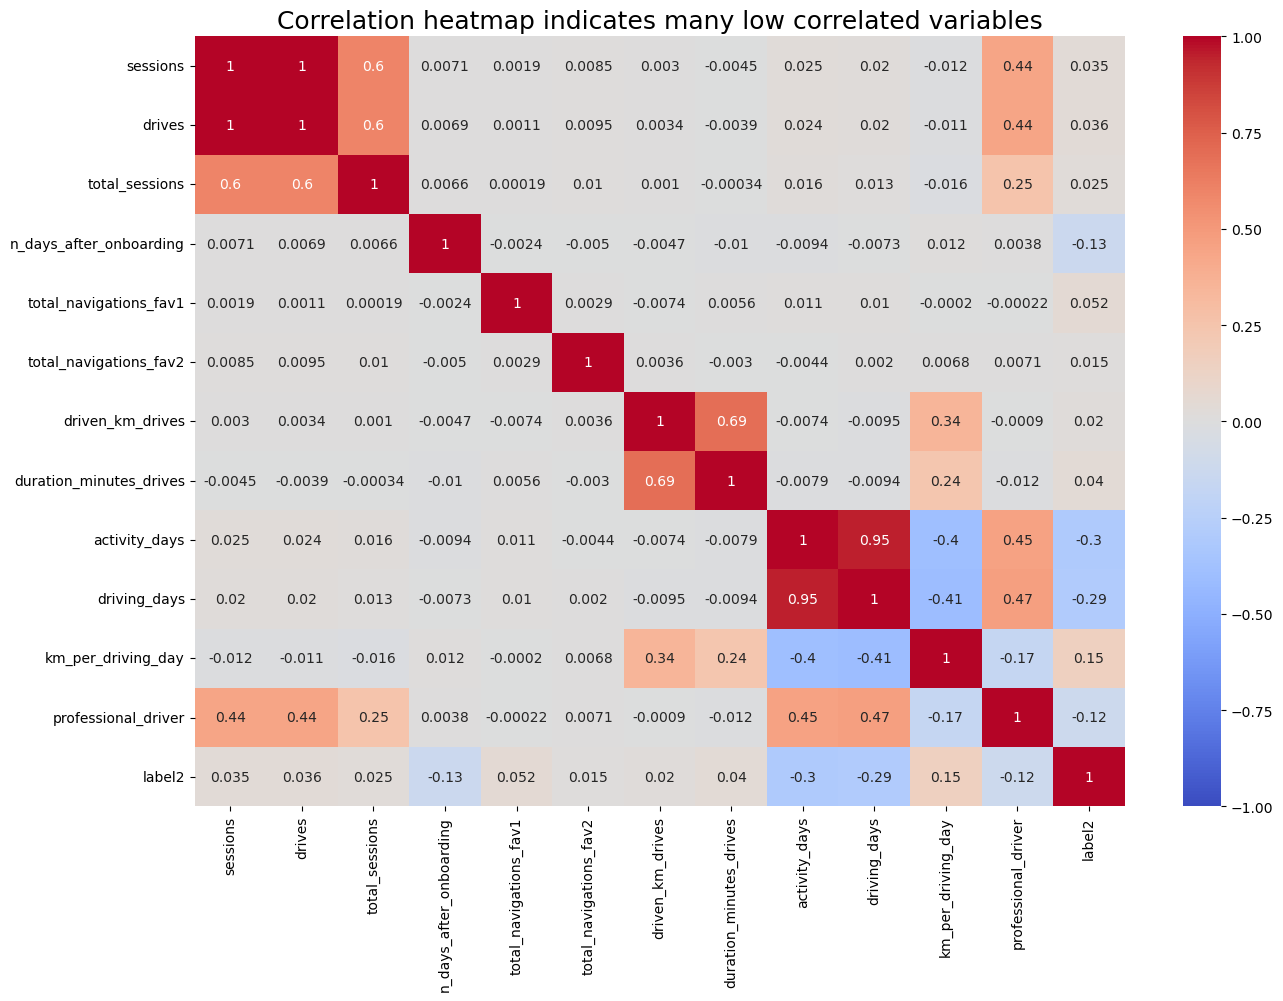

In [20]:
# Plot correlation heatmap
plt.figure(figsize=(15,10))
fig = sns.heatmap(df.corr(method='pearson', numeric_only=True), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
fig.set_title('Correlation heatmap indicates many low correlated variables', fontsize=18)
plt.show();

> For this analysis, if any two predictor variables have a Pearson correlation coefficient value greater than the *absolute value of **0.7***, only one of these two variables should be used.   
> Variables with multicollinearity:
> > 1. **`sessions` vs `drives`**: use `drives` because it has a stronger correlation with the target variable `label2` than `sessions`
> > 2. **`driving_days` vs `activity_days`**: use `activity_days` because it has a stronger correlation with the target variable `label2` than `driving_days`

### **Task 3c. Create dummies for the other categorical variable**

Creating a new, binary column called `device2` that encodes user devices as follows:

* `Android` -> `0`
* `iPhone` -> `1`

In [21]:
# Create new `device2` variable
df['device2'] = np.where(df['device']=='Android', 0, 1)

In [22]:
df.head()

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,professional_driver,label2,device2
0,retained,243,200,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,1,0,0
1,retained,133,107,326.896596,1225,19,64,8898.716275,3160.472914,13,11,iPhone,1246.901868,0,0,1
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0,0,0
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0,0,1
4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,1,0,0


### **Task 3d. Model building**

#### Assigning predictor variables and target variable: 

In [23]:
# Isolate predictor variables
X = df.drop(columns = ['label', 'label2', 'device', 'sessions', 'driving_days'])
X.head()

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,professional_driver,device2
0,200,296.748273,2276,208,0,2628.845068,1985.775061,28,138.360267,1,0
1,107,326.896596,1225,19,64,8898.716275,3160.472914,13,1246.901868,0,1
2,95,135.522926,2651,0,0,3059.148818,1610.735904,14,382.393602,0,0
3,40,67.589221,15,322,7,913.591123,587.196542,7,304.530374,0,1
4,68,168.247020,1562,166,5,3950.202008,1219.555924,27,219.455667,1,0


In [24]:
# Isolate target variable
y = df['label2']

#### **Split the data**

In [25]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [26]:
# Use .head()
X_train.head()

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,professional_driver,device2
147,108,186.192746,3116,243,124,8898.716275,4668.180092,24,612.305861,1,1
11335,2,3.487590,794,114,18,3286.545691,1780.902733,5,3286.545691,0,1
10416,139,347.106403,331,4,7,7400.838975,2349.305267,15,616.736581,0,0
646,108,455.439492,2320,11,4,6566.424830,4558.459870,18,410.401552,1,1
8002,10,89.475821,2478,135,0,1271.248661,938.711572,27,74.779333,0,1


#### Using scikit-learn to instantiate a logistic regression model and fitting the model on `X_train` and `y_train` : 
* Arguments:
    * `penalty = None` since the X predictors are unscaled.
    * `max_iter = 400`
    * `random_state = 42` for reproducibility of results. 

In [69]:
model = LogisticRegression(penalty=None, max_iter=400, random_state=42)

model.fit(X_train, y_train)

\\?\C:\Users\marco\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=400, penalty=None, random_state=42)

##### Getting the coefficients of each variable using the `.coef_` attribute: 
**Note:**
* The coefficients are in order of how the variables are listed in the dataset.
* The coefficients represent the change in the ***log odds*** of the target variable for ***every one unit increase in x***.

In [70]:
pd.Series(model.coef_[0], index=X.columns)

drives                     0.001929
total_sessions             0.000362
n_days_after_onboarding   -0.000401
total_navigations_fav1     0.001253
total_navigations_fav2     0.001009
driven_km_drives          -0.000013
duration_minutes_drives    0.000110
activity_days             -0.105181
km_per_driving_day         0.000020
professional_driver       -0.007951
device2                    0.022626
dtype: float64

##### Getting the intercept of model using `intercept_`:

In [71]:
model.intercept_

array([-0.05939485])

#### **Checking the final assumption:** Linear relationship between X and the **logit** of y using a regression plot:

In [72]:
# Get the predicted probabilities of the training data
training_probabilities = model.predict_proba(X_train)
training_probabilities

array([[0.93727955, 0.06272045],
       [0.62188201, 0.37811799],
       [0.76679708, 0.23320292],
       ...,
       [0.91800395, 0.08199605],
       [0.84879228, 0.15120772],
       [0.93329259, 0.06670741]])

In [73]:
proba_df = pd.DataFrame(training_probabilities)

> The output corresponds to the probability of each class:
> * 0 = `retained`
> * 1 = `churned`

In logistic regression, the log-odds (a.k.a, logit) of the target variable with respect to the predictor variable should be linear. The formula for calculating log-odds, where *p* is the probability response:   
<br>
$$
logit(p) = ln(\frac{p}{1-p})
$$
<br>


In [74]:
# 1. Copy the `X_train` dataframe and assign to `logit_data`
logit_data = X_train.copy()

# 2. Create a new `logit` column in the `logit_data` df
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

#### Plotting a regression plot where the x-axis represents a predictor variable and the y-axis represents the log-odds of the predicted probabilities:

In [75]:
# Helper function for regression plot logit vs predictor variable
def reg_plotter(column_str, **kwargs):                   # **kwargs = any keyword arguments from the sns.histplot()
    sns.regplot(x=column_str, y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
    plt.title(f'Log-odds: {column_str}')

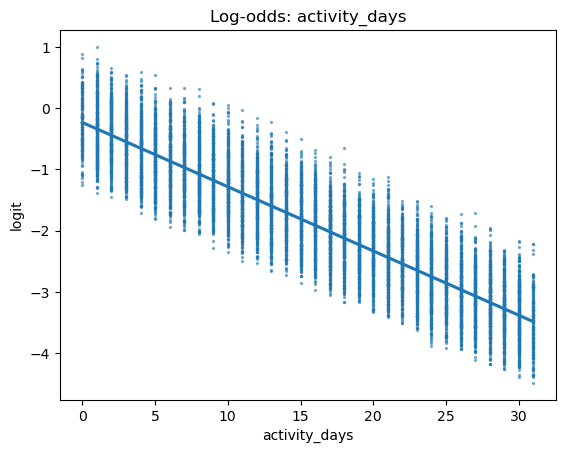

In [76]:
reg_plotter('activity_days')

## **PACE: Execute**

### **Task 4a. Results and evaluation**

If the logistic assumptions are met, the model results can be appropriately interpreted.

In [77]:
# Generate predictions on X_test
y_preds = model.predict(X_test)

In [78]:
# Score the model (accuracy) on the test data
model.score(X_test, y_test)

0.8246153846153846

> The model's **accuracy** is 82%. But accuracy is not the applicable evaluation metric for this analysis. 

### **Task 4b. Show results with a confusion matrix**

In [79]:
cm = confusion_matrix(y_test, y_preds)

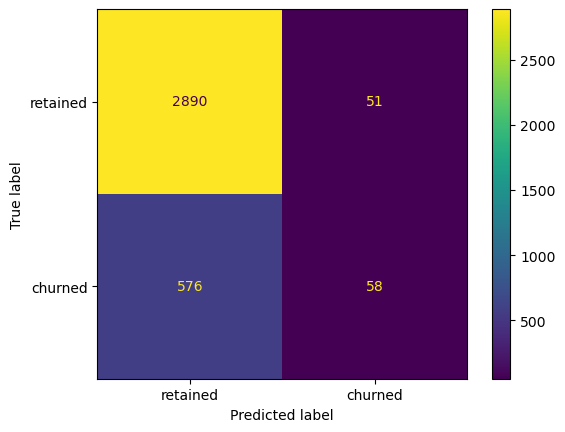

In [80]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['retained', 'churned'],
                              )
disp.plot()
plt.savefig('Confusion_matrix.png')


In [81]:
# Evaluation metrics
import sklearn.metrics as metrics
f1 = metrics.f1_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
print(f'Precision: {precision:1.4f}\nRecall: {recall:1.4f}\nf1_score: {f1:1.4f}')

Precision: 0.5321
Recall: 0.0915
f1_score: 0.1561


In [82]:
# Create classification report for logistic regression model
target_names = ['retained', 'churned']
print(classification_report(y_test, y_preds, target_names=target_names))

              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2941
     churned       0.53      0.09      0.16       634

    accuracy                           0.82      3575
   macro avg       0.68      0.54      0.53      3575
weighted avg       0.78      0.82      0.77      3575



> The model makes a lot of false negative predictions; it fails to predict users who will churn. (***Medium precision and very low recall***)

### **Feature importance**

In [83]:
# Create a list of (column_name, coefficient) tuples
feature_importance = list(zip(X_train.columns, model.coef_[0]))

# Sort the list by coefficient value
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
feature_importance

[('device2', 0.02262645578954975),
 ('drives', 0.0019294038100630048),
 ('total_navigations_fav1', 0.0012532443573928733),
 ('total_navigations_fav2', 0.0010093888100981558),
 ('total_sessions', 0.0003620025197384482),
 ('duration_minutes_drives', 0.00011020592323960809),
 ('km_per_driving_day', 1.9620154447780535e-05),
 ('driven_km_drives', -1.3151383294727781e-05),
 ('n_days_after_onboarding', -0.0004012049580132016),
 ('professional_driver', -0.007951118211239349),
 ('activity_days', -0.1051810192292094)]

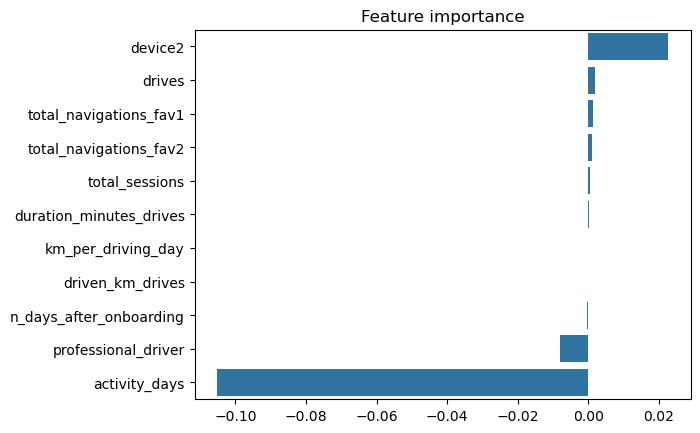

In [84]:
# Plot the feature importances
import seaborn as sns
sns.barplot(x=[x[1] for x in feature_importance],
            y=[x[0] for x in feature_importance],
            orient='h')
plt.title('Feature importance');

> The barplot above shows that in this logistic regression model, `activity_days`, `device2`, and `professional_driver` are the most helpful in predicting the outcome variable, `label2`.  

### **Task 3d. Model building: Scaling the predictor variables using `StandardScaler`**

In [85]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Select columns to be scaled
data = df.drop(columns=['label', 'device', 'professional_driver', 'label2', 'device2'])

# Initiate standard scaler 
scaler = StandardScaler()

# Transform data
scaled_df = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_df, columns=data.columns)
scaled_df.head()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day
0,2.475584,2.467716,0.952109,0.519693,0.751259,-0.740513,-0.593123,0.157532,1.381506,0.870290,-0.427253
1,0.839673,0.780672,1.206062,-0.522316,-0.768349,1.002690,2.233332,1.117027,-0.282245,-0.150957,0.640481
2,0.557107,0.562989,-0.405962,0.891485,-0.921114,-0.740513,-0.399142,-0.148801,-0.171328,-0.533924,-0.192203
3,-0.409568,-0.434726,-0.978198,-1.721964,1.667848,-0.549850,-1.366359,-0.984830,-0.947745,-1.172204,-0.267200
4,0.110949,0.073202,-0.130313,-0.188199,0.413568,-0.604325,0.002544,-0.468318,1.270590,0.742634,-0.349143


In [86]:
df1 =  df[['label', 'device', 'professional_driver', 'label2', 'device2']]

In [87]:
df2 = pd.concat([scaled_df, df1], axis = 1)

In [88]:
X2 = df2.drop(columns = ['label', 'label2', 'device', 'sessions', 'driving_days'])

In [89]:
y2 = df2['label2']

In [90]:
# Perform the train-test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, stratify=y2, random_state=42)

In [91]:
X2_train.head()

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,professional_driver,device2
147,0.798812,0.020852,1.352507,1.032668,2.636943,2.233332,2.348525,0.937839,0.029246,1,1
11335,-1.124056,-1.518154,-0.949629,-0.004525,-0.250237,-0.296632,-0.009809,-1.169578,2.605043,0,1
10416,1.361160,1.376298,-1.408668,-0.888953,-0.549850,1.558090,0.454464,-0.060411,0.033513,0,0
646,0.798812,2.288835,0.563317,-0.832671,-0.631563,1.181936,2.258906,0.272339,-0.165226,1,1
8002,-0.978933,-0.793837,0.719965,0.164321,-0.740513,-1.205127,-0.697712,1.270590,-0.488494,0,1


In [92]:
model2 = LogisticRegression(max_iter=400, random_state=42)

model2.fit(X2_train, y2_train)

LogisticRegression(max_iter=400, random_state=42)

In [93]:
# Model coefficients: 
pd.Series(model2.coef_[0], index=X2.columns)

drives                     0.108284
total_sessions             0.043816
n_days_after_onboarding   -0.403270
total_navigations_fav1     0.156233
total_navigations_fav2     0.036875
driven_km_drives          -0.026914
duration_minutes_drives    0.134120
activity_days             -0.945102
km_per_driving_day         0.020677
professional_driver       -0.021173
device2                    0.016546
dtype: float64

In [94]:
# Generate predictions on X_test
y2_preds = model2.predict(X2_test)

In [95]:
# Score the model (accuracy) on the test data
model2.score(X2_test, y2_test)

0.8240559440559441

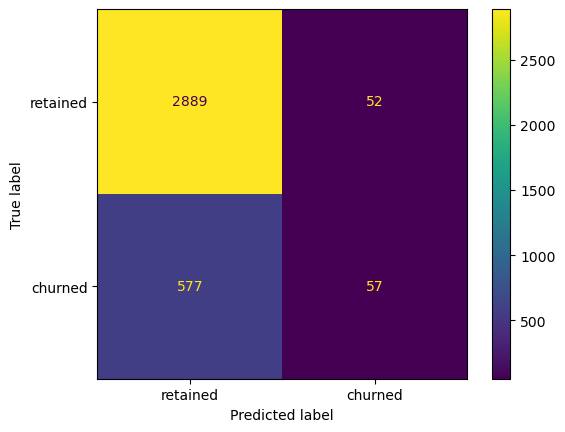

In [96]:
# Showing the results with a confusion matrix
cm2 = confusion_matrix(y2_test, y2_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, 
                              display_labels=['retained', 'churned'],
                              )
disp.plot();

In [97]:
# Evaluation metrics
import sklearn.metrics as metrics
f1 = metrics.f1_score(y2_test, y2_preds)
precision = precision_score(y2_test, y2_preds)
recall = recall_score(y2_test, y2_preds)
print(f'Precision: {precision:1.4f}\nRecall: {recall:1.4f}\nf1_score: {f1:1.4f}')

Precision: 0.5229
Recall: 0.0899
f1_score: 0.1534


In [98]:
# Create a classification report
target_labels = ['retained', 'churned']
print(classification_report(y2_test, y2_preds, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2941
     churned       0.52      0.09      0.15       634

    accuracy                           0.82      3575
   macro avg       0.68      0.54      0.53      3575
weighted avg       0.78      0.82      0.77      3575



> The model with scaled variables has an insignificant difference in recall score compared to the unscaled model. *(Recall for scaled=0.0899 vs Recall for unscaled=0.0915)*

#### Generating a bar graph of the model's coefficient for a visual presentation of the importance of the model's features. 

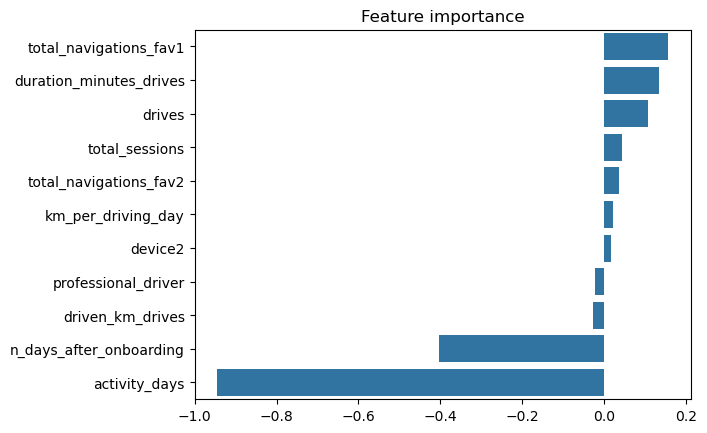

In [99]:
# Create a list of (column_name, coefficient) tuples
feature_importance2 = list(zip(X2_train.columns, model2.coef_[0]))

# Sort the list by coefficient value
feature_importance2 = sorted(feature_importance2, key=lambda x: x[1], reverse=True)

# Plot the feature importances
import seaborn as sns
sns.barplot(x=[x[1] for x in feature_importance2],
            y=[x[0] for x in feature_importance2],
            orient='h')
plt.title('Feature importance');

### Task 4c. Conclusion and recommendations

* The binomial logistic regression model was evaluated by accuracy, precision, and recall scores, with **recall being the most useful to this model since it shows the number of churned users.**
  
* **The model has a moderate precision score (53% of its positive predictions are correct) but very poor recall, with only 9% (*58 out of 634 in the test data*) of churned users identified.** The model is not a strong enough predictor because it makes a lot of false negative predictions and fails to capture users who will churn.

* **activity_days is the strongest predictor in the model**. It has a negative correlation with user churn.

* From the correlation heatmap, the user churn rate increases as the values in km_per_driving_day increase. In the model, distance driven per day was the second weakest predictor variable.
  
* Because of the model's poor performance, this model should not be used to make important business decisions. It is recommended only to use the key insights from this project milestone to guide further exploration.

*  The model results demonstrated a great need for additional data or features that strongly correlate with user churn. Also, there is a possible need to better define the user profile that this project seeks to target with the aim of increasing overall growth by preventing monthly user churn on the app. 

# [Link to the Executive Summary | Regression Modeling Results](https://docs.google.com/presentation/d/1Otnj9wWdlDhhTORXde5G6fujx_pdnttr7QL2RwX0c-8/edit?usp=sharing)